##  Amazon Fine Food Reviews Analysis

### The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.
* Number of reviews: 568,454
* Number of users: 256,059
* Number of products: 74,258
* Timespan: Oct 1999 - Oct 2012
* Number of Attributes/Columns in data: 10

### Attribute Information:
* Id
* ProductId - unique identifier for the product
* UserId - unqiue identifier for the user
* ProfileName
* HelpfulnessNumerator - number of users who found the review helpful
* HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
* Score - rating between 1 and 5
* Time - timestamp for the review
* Summary - brief summary of the review
* Text - text of the review

### Objective:

* Find the right lambda for all bow, tf-idf, avg w2v, tf-idf w2v using GridSearchCV and RandomSearchCV.
* Perform both L2 and L1 regularization.
* Plot a curve between lambda and error.
* Find the feature which are important and display them using Word of Cloud.

### Importing the libraries

In [1]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
import string
import sqlite3
from sklearn.metrics import confusion_matrix
import re
import pickle
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import gensim


### Loading the Dataset

In [2]:
con = sqlite3.connect('F:/Applied AI Course/Amazon fine food review dataset/database.sqlite')

In [3]:
#filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 """, con) 


# Give reviews with Score>3 a positive rating, and reviews with a score<3 a negative rating.
def partition(x):
    if x < 3:
        return 'negative'
    return 'positive'

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative

### Removing the duplicates

In [4]:
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)

In [5]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [1]:
final.shape

NameError: name 'final' is not defined

In [7]:
final = final.sort_values('Time',axis=0,kind="quicksort", ascending=True,inplace=False).reset_index(drop=True)

In [8]:
final.shape

(364171, 10)

### Creating a subset of the data

In [9]:
final=final.iloc[:100000,:]

In [10]:
final.shape

(100000, 10)

In [2]:
import re
import nltk
sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer
stop = set(stopwords.words('english'))

def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub('[^A-Za-z0-9]+','',sentence)
    return  cleaned


In [12]:
# this code takes a while to run as it needs to run on 500k sentences.
i=0
str1=' '
final_string=[]
all_positive_words=[] # store words from +ve reviews here
all_negative_words=[] # store words from -ve reviews here.
s=''
for sent in final['Text'].values:
    filtered_sentence=[]
    #print(sent);
    sent=cleanhtml(sent) # remove HTMl tags
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                if(cleaned_words.lower() not in stop):
                    s=(sno.stem(cleaned_words.lower())).encode('utf8')
                    filtered_sentence.append(s)
                    if (final['Score'].values)[i] == 'positive': 
                        all_positive_words.append(s) #list of all words used to describe positive reviews
                    if(final['Score'].values)[i] == 'negative':
                        all_negative_words.append(s) #list of all words used to describe negative reviews reviews
                else:
                    continue
            else:
                continue 
    #print(filtered_sentence)
    str1 = b" ".join(filtered_sentence) #final string of cleaned words
    #print("***********************************************************************")
    
    final_string.append(str1)
    i+=1


In [13]:
final['CleanedText']=final_string

In [2]:
final['CleanedText']=final['CleanedText'].str.decode("utf-8")

NameError: name 'final' is not defined

In [15]:
final.to_pickle('100k_LR_data.pkl')

In [3]:
final=pd.read_pickle('100k_LR_data.pkl')

In [4]:
X = final["CleanedText"]
y = final["Score"]

### Train Test Split

In [4]:
import math
X_1=X[:math.ceil(len(final)*.8)]
y_1=y[:math.ceil(len(final)*.8)]
X_test=X[math.ceil(len(final)*.8):]
y_test=y[math.ceil(len(final)*.8):]

print(X_1.shape,y_1.shape,X_test.shape)

(80000,) (80000,) (20000,)


In [5]:
X_train=X_1[:math.ceil(len(final)*.6)]
y_train=y_1[:math.ceil(len(final)*.6)]
X_CV=X_1[math.ceil(len(final)*.6):]
y_CV=y_1[math.ceil(len(final)*.6):]

print(X_train.shape,y_train.shape,X_CV.shape)

(60000,) (60000,) (20000,)


### Bag of Words (BoW) Vectorization Technique

In [6]:
count_vect = CountVectorizer(dtype="float") #in scikit-learn
X_train = count_vect.fit_transform(X_train)

In [7]:
X_test = count_vect.transform(X_test)
X_CV=count_vect.transform(X_CV)

In [8]:
X_train

<60000x46451 sparse matrix of type '<class 'numpy.float64'>'
	with 1802857 stored elements in Compressed Sparse Row format>

In [9]:
from sklearn.preprocessing import StandardScaler
standardized_data = StandardScaler(with_mean=False).fit_transform(X_train)
print(standardized_data.shape)

(60000, 46451)


In [30]:
print(type(standardized_data))

<class 'scipy.sparse.csr.csr_matrix'>


###  Calculate 'Lambda' using GridSearchCV

In [5]:
from sklearn.grid_search import GridSearchCV
from sklearn.linear_model import LogisticRegression

C:\Users\abc\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Users\abc\Anaconda3\lib\site-packages\sklearn\grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [11]:
tuned_parameters = [{'C': [10**-4, 10**-2, 10**0, 10**2, 10**4]}]
model = GridSearchCV(LogisticRegression(), tuned_parameters, scoring = 'f1_weighted', cv=5)
model.fit(X_train, y_train)

print(model.best_estimator_)
print(model.score(X_test, y_test))

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
0.91793642659


* Here Lambda comes out to be 1

###  Calculate 'Lambda' using RandomizedSearchCV

In [6]:
from sklearn.model_selection import RandomizedSearchCV

In [15]:
tuned_parameters = {'C': [10**-4, 10**-2, 10**0, 10**2, 10**4]}

In [18]:
model1 = RandomizedSearchCV(LogisticRegression(), tuned_parameters, scoring = 'f1_weighted', cv=5, n_iter=3)

In [19]:
model1.fit(X_train, y_train)

print(model1.best_estimator_)
print(model1.score(X_test, y_test))

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
0.91793642659


* Here Lambda comes out to be 1

In [68]:
clf = LogisticRegression(C=1, penalty='l2')

In [69]:
clf.fit(X_train, y_train)

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [70]:
pred = clf.predict(X_test)

In [7]:
from sklearn.metrics import f1_score

In [25]:
f1_value = f1_score(y_test, pred,average='weighted') * float(100)
print('\nThe F1-Score for L2 Regularization is %f%%' % (f1_value))


The F1-Score for L2 Regularization is 91.793643%


In [26]:
clf1 = LogisticRegression(C=1, penalty='l1')

In [27]:
clf1.fit(X_train, y_train)

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [28]:
pred = clf1.predict(X_test)

In [29]:
f1_value = f1_score(y_test, pred,average='weighted') * float(100)
print('\nThe F1-Score for L1 Regularization is %f%%' % (f1_value))


The F1-Score for L1 Regularization is 91.769805%


### Confusion Matrix

In [8]:
import seaborn as sns

In [74]:
array=confusion_matrix(y_test, pred )

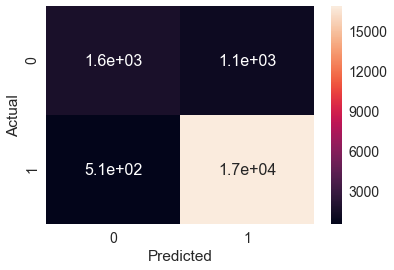

In [75]:

df_cm = pd.DataFrame(array, range(2),
                  range(2))
#plt.figure(figsize = (10,7))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16})
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

### confusion matrix described

In above confusion matrix(used to describe performence of classifier)

* tn(true negative) = 1600, tp(true positive) = 17000, fn(false negative) = 5100, fp(false positive) = 1100
* precision --> When it predicts +ve, how often is it correct? = tp/predicted +ve = 17000/18100 = ~93.9%
* True Positive rate(tpr)/recall --> When it is actually +ve, how often does it predict +ve? = tp/(real/true/actual +ve) = 17000/22100 = ~76.9%
* Specificity(True Negative Rate)--> When it's actually no, how often does it predict no? = tn/actual negative = 1600/2700 = ~59.2%.
* False Positive rate --> when it is actually -ve, how often does it predicted +ve = fp/actual-ve = 1100/2700 = ~40.7%

In [9]:
Lambdas = [10**-4,10**-2,10**0,10**2,10**4]

In [32]:
cv_scores = []

   
for k in Lambdas:
    clf1 = LogisticRegression(C=1/k, penalty='l1')
     # fitting the model on crossvalidation train
    clf1.fit(X_train, y_train)
    # predict the response on the crossvalidation train
    pred = clf1.predict(X_CV)
     # evaluate CV accuracy
    f1_value = f1_score(y_CV, pred, average='weighted') * float(100)
    cv_scores.append(f1_value)

In [33]:
MSE = [100 - x for x in cv_scores]

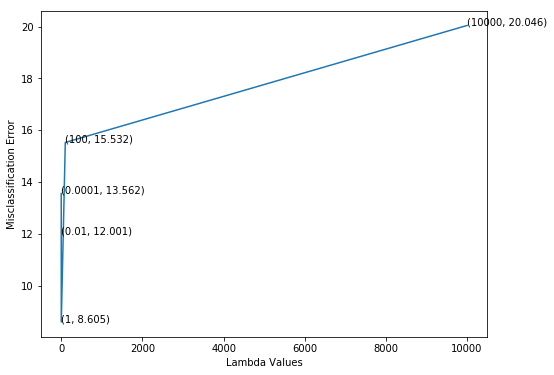

In [34]:
plt.figure(figsize=(8,6))
plt.plot(Lambdas, MSE)

for xy in zip(Lambdas, np.round(MSE,3)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')

plt.xlabel('Lambda Values')
plt.ylabel('Misclassification Error')
plt.show()

In [35]:
print("the misclassification error for each lambda value is : ", np.round(MSE,3))

the misclassification error for each lambda value is :  [ 13.562  12.001   8.605  15.532  20.046]


In [14]:
Sparsity_scores = []

   
for k in Lambdas:
    clf1 = LogisticRegression(C=1/k, penalty='l1')
     # fitting the model on crossvalidation train
    clf1.fit(X_train, y_train)
    w = clf1.coef_
    print(np.count_nonzero(w))
    Sparsity_scores.append(np.count_nonzero(w))

19565
10801
3437
95
0


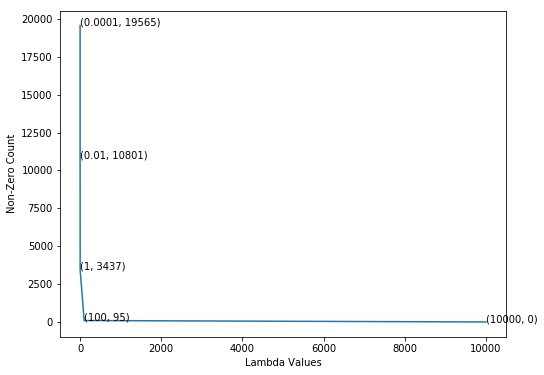

In [15]:
plt.figure(figsize=(8,6))
plt.plot(Lambdas, Sparsity_scores)

for xy in zip(Lambdas, Sparsity_scores):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')

plt.xlabel('Lambda Values')
plt.ylabel('Non-Zero Count')
plt.show()

### Observations

As lambda increases non-zero values should decrease. 

### Feature Importance

In [133]:
clf = LogisticRegression(C=1, penalty='l1'); # Checking for multicollinearity through Pertubation test
clf.fit(X_train, y_train);
w = clf.coef_

In [134]:
print(w)

[[ 0.  0.  0. ...,  0.  0.  0.]]


In [135]:
epsilon = np.random.normal(loc=0.0, scale=0.00000001)

In [136]:
X_train.data = X_train.data + epsilon

In [137]:
clf1 = LogisticRegression(C=1, penalty='l1'); # Checking for multicollinearity through Pertubation test
clf1.fit(X_train, y_train);
w1 = clf1.coef_

In [138]:
print(w1)

[[ 0.  0.  0. ...,  0.  0.  0.]]


In [139]:
w=w.tolist()

In [140]:
w1=w1.tolist()

In [143]:
percent_change=[-9999 if x == 0 else (((y - x) * 100)) for x, y in zip(w[0], w1[0])]

In [145]:
all_features=count_vect.get_feature_names()
all_nd_features=np.array(all_features)

In [146]:
feature_dict=dict(zip(all_nd_features,percent_change))

In [148]:
features_dic = {k:v for k,v in feature_dict.items() if v != -9999}

In [150]:
print(len(features_dic))

1136


In [151]:
features_dict = {k:v for k,v in features_dic.items() if v <0.4}

In [152]:
print(len(features_dict))

1136


In [153]:
top_100_features=sorted(features_dict, key=features_dict.get, reverse=True)[:100]

In [9]:
from collections import Counter
from wordcloud import WordCloud

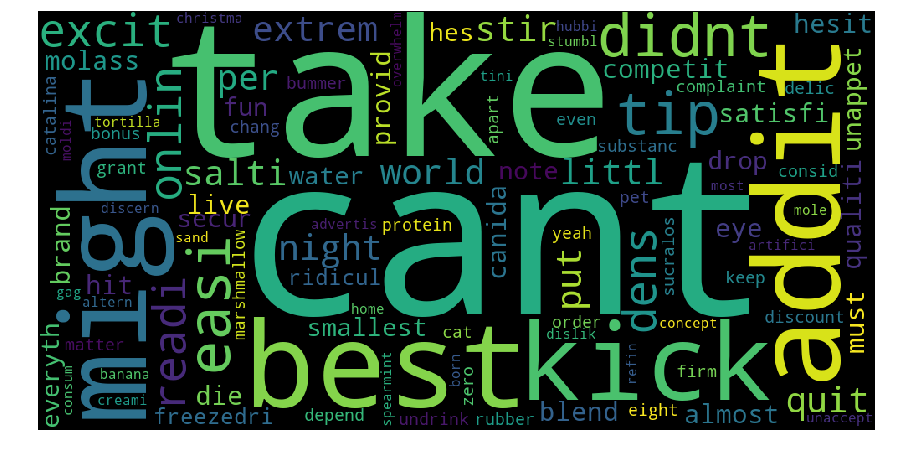

In [154]:

word_could_dict=Counter(top_100_features)
wordcloud = WordCloud(width = 1000, height = 500).generate_from_frequencies(word_could_dict)

plt.figure(figsize=(15,8))
plt.imshow(wordcloud)
plt.axis("off") 
plt.show()

### tf-idf Vectorization Technique

In [86]:
X_1=X[:math.ceil(len(final)*.8)]
y_1=y[:math.ceil(len(final)*.8)]
X_test=X[math.ceil(len(final)*.8):]
y_test=y[math.ceil(len(final)*.8):]

print(X_1.shape,y_1.shape,X_test.shape)

(80000,) (80000,) (20000,)


In [87]:
X_train=X_1[:math.ceil(len(final)*.6)]
y_train=y_1[:math.ceil(len(final)*.6)]
X_CV=X_1[math.ceil(len(final)*.6):]
y_CV=y_1[math.ceil(len(final)*.6):]

print(X_train.shape,y_train.shape,X_CV.shape)

(60000,) (60000,) (20000,)


In [89]:
tf_idf_vect = TfidfVectorizer(dtype='float')
X_train = tf_idf_vect.fit_transform(X_train)

In [90]:
X_test=tf_idf_vect.transform(X_test)
X_CV=tf_idf_vect.transform(X_CV)

In [91]:
X_train

<60000x46451 sparse matrix of type '<class 'numpy.float64'>'
	with 1802857 stored elements in Compressed Sparse Row format>

In [92]:
from sklearn.preprocessing import StandardScaler
standardized_data = StandardScaler(with_mean=False).fit_transform(X_train)
print(standardized_data.shape)

(60000, 46451)


###  Calculate 'Lambda' using GridSearchCV

In [93]:
tuned_parameters = [{'C': [10**-4, 10**-2, 10**0, 10**2, 10**4]}]
model = GridSearchCV(LogisticRegression(), tuned_parameters, scoring = 'f1_weighted', cv=5)
model.fit(X_train, y_train)

print(model.best_estimator_)
print(model.score(X_test, y_test))

LogisticRegression(C=100, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
0.910399481984


* Here Lambda comes out to be 0.01

###  Calculate 'Lambda' using RandomizedSearchCV

In [96]:
tuned_parameters = {'C': [10**-4, 10**-2, 10**0, 10**2, 10**4]}
model1 = RandomizedSearchCV(LogisticRegression(), tuned_parameters, scoring = 'f1_weighted', cv=5, n_iter=3)
model1.fit(X_train, y_train)

print(model1.best_estimator_)
print(model1.score(X_test, y_test))

LogisticRegression(C=10000, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
0.879338082952


* Here Lambda comes out to be 0.0001

### Observations:

So from observation best lambda is 0.01 because model score corresponding to it is high i.e C will be 100

### LogisticRegression using L2 Regularization

In [98]:
clf = LogisticRegression(C=100, penalty='l2')
clf.fit(X_train, y_train)
pred = clf.predict(X_test)

In [99]:
f1_value = f1_score(y_test, pred,average='weighted') * float(100)
print('\nThe F1-Score for L2 Regularization is %f%%' % (f1_value))


The F1-Score for L2 Regularization is 91.039948%


### LogisticRegression using L1 Regularization

In [100]:
clf1 = LogisticRegression(C=100, penalty='l1')
clf1.fit(X_train, y_train)
pred = clf1.predict(X_test)

In [101]:
f1_value = f1_score(y_test, pred,average='weighted') * float(100)
print('\nThe F1-Score for L2 Regularization is %f%%' % (f1_value))


The F1-Score for L2 Regularization is 88.880988%


### Observation

F1 Score corresponding to L2 Regularization is high

### Confusion Matrix

In [102]:
array=confusion_matrix(y_test, pred )

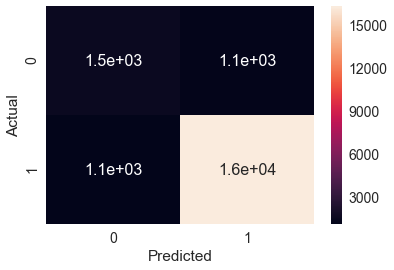

In [103]:
df_cm = pd.DataFrame(array, range(2),
                  range(2))
#plt.figure(figsize = (10,7))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16})
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

### confusion matrix described

In above confusion matrix(used to describe performence of classifier)

* tn(true negative) = 1500, tp(true positive) = 16000, fn(false negative) = 1100, fp(false positive) = 1100
* precision --> When it predicts +ve, how often is it correct? = tp/predicted +ve = 16000/17100 = ~93.5%
* True Positive rate(tpr)/recall --> When it is actually +ve, how often does it predict +ve? = tp/(real/true/actual +ve) = 16000/17100 = ~93.5%
* Specificity(True Negative Rate)--> When it's actually no, how often does it predict no? = tn/actual negative = 1500/2600 = ~57.6%.
* False Positive rate --> when it is actually -ve, how often does it predicted +ve = fp/actual-ve = 1100/2600 = ~42.3%

### lambda vs error 

In [105]:
cv_scores = []

   
for k in Lambdas:
    clf1 = LogisticRegression(C=1/k, penalty='l1')
     # fitting the model on crossvalidation train
    clf1.fit(X_train, y_train)
    # predict the response on the crossvalidation train
    
    pred = clf1.predict(X_CV)
     # evaluate CV accuracy
    f1_value = f1_score(y_CV, pred, average='weighted') * float(100)
    cv_scores.append(f1_value)
    
    

In [106]:
MSE = [100 - x for x in cv_scores]

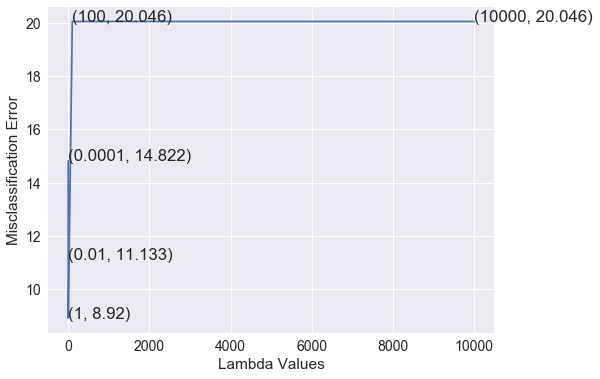

In [107]:
plt.figure(figsize=(8,6))
plt.plot(Lambdas, MSE)

for xy in zip(Lambdas, np.round(MSE,3)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')

plt.xlabel('Lambda Values')
plt.ylabel('Misclassification Error')
plt.show()

### Feature Importance

In [109]:
clf = LogisticRegression(C=100, penalty='l1'); # Checking for multicollinearity through Pertubation test
clf.fit(X_train, y_train);
w = clf.coef_

In [110]:
print(w)

[[ 0.  0.  0. ...,  0.  0.  0.]]


In [111]:
epsilon = np.random.normal(loc=0.0, scale=0.00000001)

In [112]:
X_train.data = X_train.data + epsilon

In [114]:
clf1 = LogisticRegression(C=100, penalty='l1'); # Checking for multicollinearity through Pertubation test
clf1.fit(X_train, y_train);
w1 = clf1.coef_

In [115]:
print(w1)

[[ 0.  0.  0. ...,  0.  0.  0.]]


In [116]:
w=w.tolist()
w1=w1.tolist()

In [119]:
percent_change=[-9999 if x == 0 else (((y - x) * 100)) for x, y in zip(w[0], w1[0])]

In [121]:
all_features=tf_idf_vect.get_feature_names()
all_nd_features=np.array(all_features)

In [122]:
feature_dict=dict(zip(all_nd_features,percent_change))

In [124]:
features_dic = {k:v for k,v in feature_dict.items() if v != -9999}

In [126]:
print(len(features_dic))

10694


In [127]:
features_dict = {k:v for k,v in features_dic.items() if v <0.4}

In [128]:
print(len(features_dict))

8649


In [129]:
top_100_features=sorted(features_dict, key=features_dict.get, reverse=True)[:100]

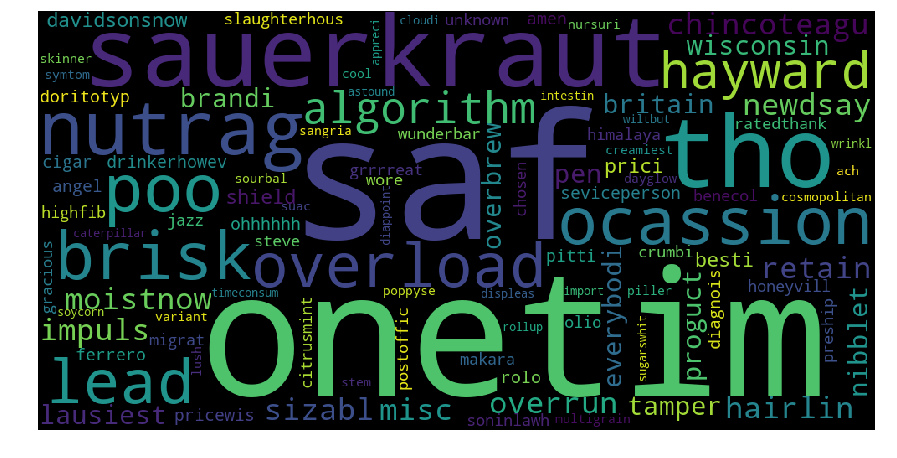

In [132]:
word_could_dict=Counter(top_100_features)
wordcloud = WordCloud(width = 1000, height = 500).generate_from_frequencies(word_could_dict)

plt.figure(figsize=(15,8))
plt.imshow(wordcloud)
plt.axis("off") 
plt.show()

### W2V Vectorization Technique

In [83]:
from gensim.models import Word2Vec
import math
X_1=X[:math.ceil(len(final)*.8)]
y_1=y[:math.ceil(len(final)*.8)]
X_test=X[math.ceil(len(final)*.8):]
y_test=y[math.ceil(len(final)*.8):]

X_train=X_1[:math.ceil(len(final)*.6)]
y_train=y_1[:math.ceil(len(final)*.6)]
X_CV=X_1[math.ceil(len(final)*.6):]
y_CV=y_1[math.ceil(len(final)*.6):]

print(X_train.shape,y_train.shape,X_CV.shape,X_test.shape)

(60000,) (60000,) (20000,) (20000,)


In [84]:
# Train your own Word2Vec model using your own train corpus
import gensim


list_of_sent=[]
    
for sent in X_train:
    filtered_sentence=[]
    sent=cleanhtml(sent)
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if(cleaned_words.isalpha()):    
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue 
    list_of_sent.append(filtered_sentence)

In [85]:
print(list_of_sent[0])

['witti', 'littl', 'book', 'make', 'son', 'laugh', 'loud', 'recit', 'car', 'drive', 'along', 'alway', 'sing', 'refrain', 'hes', 'learn', 'whale', 'india', 'droop', 'rose', 'love', 'new', 'word', 'book', 'introduc', 'silli', 'classic', 'book', 'will', 'bet', 'son', 'still', 'abl', 'recit', 'memori', 'colleg']


In [86]:
print(len(list_of_sent))

60000


In [87]:
w2v_model=gensim.models.Word2Vec(list_of_sent,min_count=5,size=50, workers=4)

In [64]:
w2v_model

In [88]:
w2v_model.wv.most_similar('tasti')

[('delici', 0.755781888961792),
 ('yummi', 0.7281292676925659),
 ('nice', 0.6621577143669128),
 ('satisfi', 0.655113697052002),
 ('hearti', 0.6264991760253906),
 ('good', 0.6235668063163757),
 ('nutriti', 0.614248514175415),
 ('substanti', 0.6064737439155579),
 ('crisp', 0.5805913805961609),
 ('dens', 0.5759779214859009)]

In [89]:
w2v_model.wv.most_similar('like')

[('weird', 0.6803443431854248),
 ('okay', 0.6632471084594727),
 ('prefer', 0.635013222694397),
 ('remind', 0.6315659284591675),
 ('gross', 0.6286604404449463),
 ('think', 0.6186091899871826),
 ('bland', 0.6102612614631653),
 ('want', 0.6005869507789612),
 ('good', 0.5929507613182068),
 ('dislik', 0.5920083522796631)]

In [90]:
w2v = list(w2v_model.wv.vocab)

In [91]:
print("number of words that occured minimum 5 times ",len(w2v))

number of words that occured minimum 5 times  10609


In [92]:
print(w2v[:50])

['witti', 'littl', 'book', 'make', 'son', 'laugh', 'loud', 'car', 'drive', 'along', 'alway', 'sing', 'refrain', 'hes', 'learn', 'whale', 'india', 'droop', 'rose', 'love', 'new', 'word', 'introduc', 'silli', 'classic', 'will', 'bet', 'still', 'abl', 'memori', 'colleg', 'rememb', 'see', 'show', 'air', 'televis', 'year', 'ago', 'child', 'sister', 'later', 'bought', 'day', 'thirti', 'use', 'seri', 'amp', 'song', 'student', 'teach']


### Average W2V

In [21]:
# average Word2Vec
# compute average word2vec for each review.
from tqdm import tqdm
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(X_train.values): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent.split(): # for each word in a review/sentence
        if word in w2v:
            
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

100%|███████████████████████████████████████████████████████████████████████████| 60000/60000 [02:16<00:00, 441.17it/s]


60000
50


In [22]:
sent_vectors[0]

array([ 0.07849627,  0.06921322, -0.19591464,  0.264651  , -0.39982177,
       -0.00794701,  0.17013798, -0.04677698, -0.54125436, -0.17099738,
       -0.02201867, -0.37613071,  0.20024914,  0.14990879, -0.03107493,
       -0.16790533, -0.37631495, -0.24115034,  0.46180345,  0.03877828,
        0.04659917,  0.64691152,  0.03096659,  0.37732324, -0.63960333,
        0.10554524,  0.01626724,  0.38925252,  0.25229098, -0.42370235,
       -0.40179075,  0.51357463, -0.09648283, -0.04041164, -0.13728761,
        0.34259769, -0.12532861,  0.02881061,  0.37194802,  0.2380228 ,
        0.94484085, -0.07923452, -0.07536329, -0.03628757,  0.34557156,
       -0.0576404 ,  0.19671213,  0.19499085, -0.26005682, -0.4554046 ])

In [23]:
# average Word2Vec
# compute average word2vec for each review.

sent_vectors_test = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(X_test): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent.split(): # for each word in a review/sentence
        if word in w2v:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_test.append(sent_vec)
print(len(sent_vectors_test))
print(len(sent_vectors_test[0]))

100%|███████████████████████████████████████████████████████████████████████████| 20000/20000 [00:53<00:00, 371.79it/s]


20000
50


In [24]:
# average Word2Vec
# compute average word2vec for each review.

sent_vectors_CV = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(X_CV): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent.split(): # for each word in a review/sentence
        if word in w2v:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_CV.append(sent_vec)
print(len(sent_vectors_CV))
print(len(sent_vectors_CV[0]))

100%|███████████████████████████████████████████████████████████████████████████| 20000/20000 [00:48<00:00, 411.00it/s]


20000
50


In [25]:
X_train = sent_vectors
X_test = sent_vectors_test
X_CV= sent_vectors_CV

###  Calculate 'Lambda' using GridSearchCV

In [26]:
tuned_parameters = [{'C': [10**-4, 10**-2, 10**0, 10**2, 10**4]}]
model = GridSearchCV(LogisticRegression(), tuned_parameters, scoring = 'f1_weighted', cv=5)
model.fit(X_train, y_train)

print(model.best_estimator_)
print(model.score(X_test, y_test))

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
0.874842235735


* Here Lambda comes out to be 1

###  Calculate 'Lambda' using RandomizedSearchCV

In [27]:
tuned_parameters = {'C': [10**-4, 10**-2, 10**0, 10**2, 10**4]}
model1 = RandomizedSearchCV(LogisticRegression(), tuned_parameters, scoring = 'f1_weighted', cv=5, n_iter=3)
model1.fit(X_train, y_train)

print(model1.best_estimator_)
print(model1.score(X_test, y_test))

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
0.874842235735


* Here Lambda comes out to be 1

### LogisticRegression using L2 Regularization

In [28]:
clf = LogisticRegression(C=1, penalty='l2')
clf.fit(X_train, y_train)
pred = clf.predict(X_test)

In [29]:
f1_value = f1_score(y_test, pred,average='weighted') * float(100)
print('\nThe F1-Score for L2 Regularization is %f%%' % (f1_value))


The F1-Score for L2 Regularization is 87.484224%


### LogisticRegression using L1 Regularization

In [30]:
clf1 = LogisticRegression(C=1, penalty='l1')
clf1.fit(X_train, y_train)
pred1 = clf1.predict(X_test)

In [31]:
f1_value = f1_score(y_test, pred1, average='weighted') * float(100)
print('\nThe F1-Score for L1 Regularization is %f%%' % (f1_value))


The F1-Score for L1 Regularization is 87.483582%


### Confusion Matrix

In [32]:
array=confusion_matrix(y_test, pred )

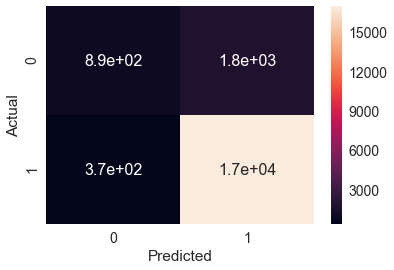

In [33]:
df_cm = pd.DataFrame(array, range(2),
                  range(2))
#plt.figure(figsize = (10,7))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16})
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

### confusion matrix described

In above confusion matrix(used to describe performence of classifier)

* tn(true negative) = 890, tp(true positive) = 17000, fn(false negative) = 370, fp(false positive) = 1800
* precision --> When it predicts +ve, how often is it correct? = tp/predicted +ve = 17000/18800 = ~90.4%
* True Positive rate(tpr)/recall --> When it is actually +ve, how often does it predict +ve? = tp/(real/true/actual +ve) = 17000/17340 = ~98%
* Specificity(True Negative Rate)--> When it's actually no, how often does it predict no? = tn/actual negative = 890/2690 = ~33%.
* False Positive rate --> when it is actually -ve, how often does it predicted +ve = fp/actual-ve = 1800/2690 = ~66.9%

### lambda vs error and sparsity

In [34]:
cv_scores = []
Sparsity_scores=[]
   
for k in Lambdas:
    clf1 = LogisticRegression(C=1/k, penalty='l1')
     # fitting the model on crossvalidation train
    clf1.fit(X_train, y_train)
    # predict the response on the crossvalidation train
    
    pred = clf1.predict(X_CV)
     # evaluate CV accuracy
    f1_value = f1_score(y_CV, pred, average='weighted') * float(100)
    cv_scores.append(f1_value)
    w = clf1.coef_
    print(np.count_nonzero(w))
    Sparsity_scores.append(np.count_nonzero(w))
   

50
50
50
35
0


In [35]:
MSE = [100 - x for x in cv_scores]

In [36]:
MSE

[12.178645148086176,
 12.15967090947791,
 12.185133167174953,
 13.875716020067344,
 20.046269457863659]

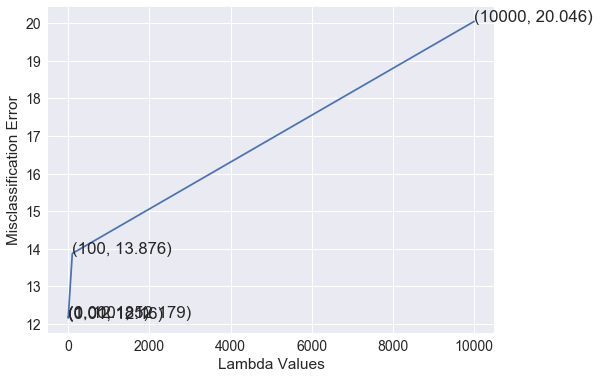

In [37]:
plt.figure(figsize=(8,6))
plt.plot(Lambdas, MSE)

for xy in zip(Lambdas, np.round(MSE,3)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')

plt.xlabel('Lambda Values')
plt.ylabel('Misclassification Error')
plt.show()

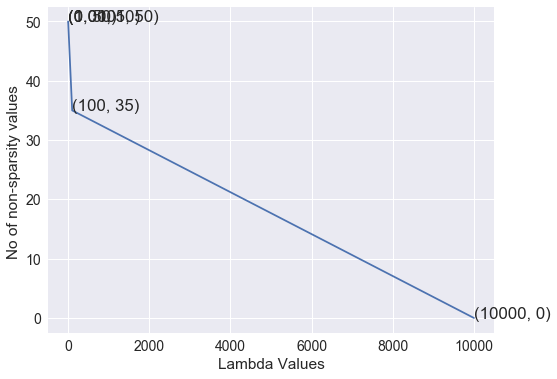

In [38]:
plt.figure(figsize=(8,6))
plt.plot(Lambdas,  Sparsity_scores)

for xy in zip(Lambdas, ( Sparsity_scores)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')

plt.xlabel('Lambda Values')
plt.ylabel('No of non-sparsity values ')
plt.show()

### Feature Importance

In [39]:
clf = LogisticRegression(C=1, penalty='l1') # Checking for multicollinearity through Pertubation test
clf.fit(X_train, y_train)
w = clf.coef_

In [44]:
epsilon = np.random.normal(loc=0.0, scale=0.00000001)
epsilon

-4.537670029363291e-09

In [45]:
X_train = X_train + np.array(epsilon)

In [47]:
clf1 = LogisticRegression(C=1, penalty='l1'); # Checking for multicollinearity through Pertubation test
clf1.fit(X_train, y_train);
w1 = clf1.coef_

In [49]:
w=w.tolist()

In [50]:
w1=w1.tolist()

In [51]:
percent_change=[-9999 if x == 0 else (((y - x) * 100)) for x, y in zip(w[0], w1[0])]

### tf-idf W2V Vectorization Technique

In [93]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(X_train.values)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [ ]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(X_train.values): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent.split(): # for each word in a review/sentence
        if word in w2v:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*sent.count(word)
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

In [ ]:

tfidf_sent_vectors_test = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(X_test): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent.split(): # for each word in a review/sentence
        if word in w2v:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*sent.count(word)
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_test.append(sent_vec)
    row += 1

In [ ]:

tfidf_sent_vectors_CV = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(X_CV): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent.split(): # for each word in a review/sentence
        if word in w2v:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*sent.count(word)
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_CV.append(sent_vec)
    row += 1

In [99]:
X_train = tfidf_sent_vectors
X_test = tfidf_sent_vectors_test
X_CV=tfidf_sent_vectors_CV

###  Calculate 'Lambda' using GridSearchCV

In [101]:
tuned_parameters = [{'C': [10**-4, 10**-2, 10**0, 10**2, 10**4]}]
model = GridSearchCV(LogisticRegression(), tuned_parameters, scoring = 'f1_weighted', cv=5)
model.fit(X_train, y_train)

print(model.best_estimator_)
print(model.score(X_test, y_test))

LogisticRegression(C=100, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
0.857600409735


* Here Lambda comes out to be 0.01

###  Calculate 'Lambda' using RandomizedSearchCV

In [102]:
tuned_parameters = {'C': [10**-4, 10**-2, 10**0, 10**2, 10**4]}
model1 = RandomizedSearchCV(LogisticRegression(), tuned_parameters, scoring = 'f1_weighted', cv=5, n_iter=3)
model1.fit(X_train, y_train)

print(model1.best_estimator_)
print(model1.score(X_test, y_test))

LogisticRegression(C=10000, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
0.857600409735


* Here Lambda comes out to be 0.0001

### LogisticRegression using L2 Regularization

In [103]:
clf = LogisticRegression(C=100, penalty='l2')
clf.fit(X_train, y_train)
pred = clf.predict(X_test)

In [104]:
f1_value = f1_score(y_test, pred,average='weighted') * float(100)
print('\nThe F1-Score for L2 Regularization is %f%%' % (f1_value))


The F1-Score for L2 Regularization is 85.760041%


### LogisticRegression using L1 Regularization

In [105]:
clf1 = LogisticRegression(C=100, penalty='l1')
clf1.fit(X_train, y_train)
pred1 = clf1.predict(X_test)

In [106]:
f1_value = f1_score(y_test, pred1,average='weighted') * float(100)
print('\nThe F1-Score for L1 Regularization is %f%%' % (f1_value))


The F1-Score for L1 Regularization is 85.763882%


In [108]:
array=confusion_matrix(y_test, pred1 )

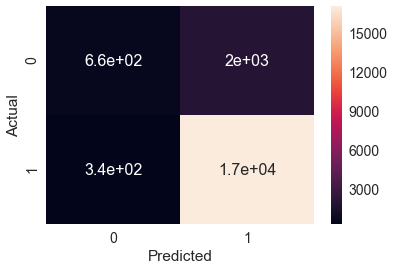

In [109]:
df_cm = pd.DataFrame(array, range(2),
                  range(2))
#plt.figure(figsize = (10,7))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16})
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

### confusion matrix described

In above confusion matrix(used to describe performence of classifier)

* tn(true negative) = 660, tp(true positive) = 17000, fn(false negative) = 340, fp(false positive) = 2000
* precision --> When it predicts +ve, how often is it correct? = tp/predicted +ve = 17000/19000 = ~89.4%
* True Positive rate(tpr)/recall --> When it is actually +ve, how often does it predict +ve? = tp/(real/true/actual +ve) = 17000/17340 = ~98%
* Specificity(True Negative Rate)--> When it's actually no, how often does it predict no? = tn/actual negative = 660/2660 = ~24.8%.
* False Positive rate --> when it is actually -ve, how often does it predicted +ve = fp/actual-ve = 2000/2660 = ~75.1%

### lambda vs error and sparsity

In [110]:
cv_scores = []
Sparsity_scores=[]
   
for k in Lambdas:
    clf1 = LogisticRegression(C=1/k, penalty='l1')
     # fitting the model on crossvalidation train
    clf1.fit(X_train, y_train)
    # predict the response on the crossvalidation train
    
    pred = clf1.predict(X_CV)
     # evaluate CV accuracy
    f1_value = f1_score(y_CV, pred, average='weighted') * float(100)
    cv_scores.append(f1_value)
    w = clf1.coef_
    print(np.count_nonzero(w))
    Sparsity_scores.append(np.count_nonzero(w))

50
50
49
37
0


In [111]:
MSE = [100 - x for x in cv_scores]

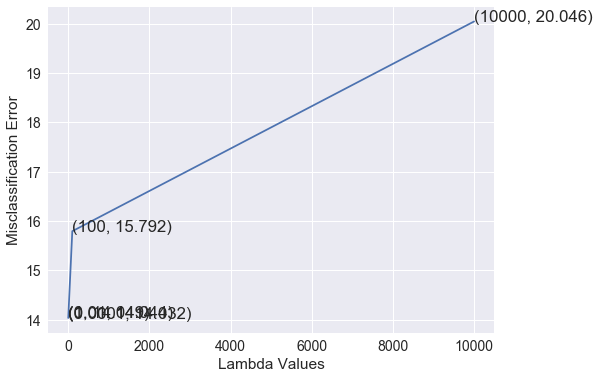

In [113]:
plt.figure(figsize=(8,6))
plt.plot(Lambdas, MSE)

for xy in zip(Lambdas, np.round(MSE,3)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')

plt.xlabel('Lambda Values')
plt.ylabel('Misclassification Error')
plt.show()

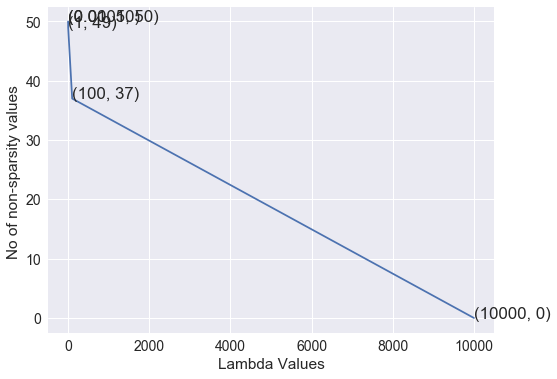

In [114]:
plt.figure(figsize=(8,6))
plt.plot(Lambdas,  Sparsity_scores)

for xy in zip(Lambdas, ( Sparsity_scores)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')

plt.xlabel('Lambda Values')
plt.ylabel('No of non-sparsity values ')
plt.show()

### Feature Importance

In [115]:
clf = LogisticRegression(C=100, penalty='l1') # Checking for multicollinearity through Pertubation test
clf.fit(X_train, y_train)
w = clf.coef_

In [117]:
epsilon = np.random.normal(loc=0.0, scale=0.00000001)

In [118]:
X_train = X_train + np.array(epsilon)

In [119]:
clf1 = LogisticRegression(C=100, penalty='l1') # Checking for multicollinearity through Pertubation test
clf1.fit(X_train, y_train)
w1 = clf1.coef_

In [121]:
w=w.tolist()
w1=w1.tolist()

In [122]:
percent_change=[-9999 if x == 0 else (((y - x) * 100)) for x, y in zip(w[0], w1[0])]

In [124]:
percent_change.sort(reverse=True)

In [16]:
from prettytable import PrettyTable
    
x = PrettyTable()

In [17]:
x.field_names = ["Vectorization_Technique", "Lambda(GridSearch)", "Lambda(RandomSearch)", "F1-Score(L2 Norm)", "F1-Score(L1 Norm)"]

In [18]:
x.add_row(["BOW", 1 ,1, 91.79, 91.76 ])

In [19]:
x.add_row(["tf-idf", 0.01,0.0001,91.03,88.88])

In [20]:
x.add_row(["Average W2V", 1,1,87.484,87.483])

In [21]:
x.add_row(["tf-idf W2V", 0.01,0.0001,85.760,85.763])

In [22]:
print(x)

+-------------------------+--------------------+----------------------+-------------------+-------------------+
| Vectorization_Technique | Lambda(GridSearch) | Lambda(RandomSearch) | F1-Score(L2 Norm) | F1-Score(L1 Norm) |
+-------------------------+--------------------+----------------------+-------------------+-------------------+
|           BOW           |         1          |          1           |       91.79       |       91.76       |
|          tf-idf         |        0.01        |        0.0001        |       91.03       |       88.88       |
|       Average W2V       |         1          |          1           |       87.484      |       87.483      |
|        tf-idf W2V       |        0.01        |        0.0001        |       85.76       |       85.763      |
+-------------------------+--------------------+----------------------+-------------------+-------------------+


### Conclusion:

Based on the above table it is concluded that BOW vectorization technique performs better due to its high f1-score on both L1 and L2 regularization.